Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step - loss: 98.4526 - mae: 9.9223
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 96.0053 - mae: 9.7982
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 92.5316 - mae: 9.6193
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 84.9070 - mae: 9.2145
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 85.9039 - mae: 9.2684


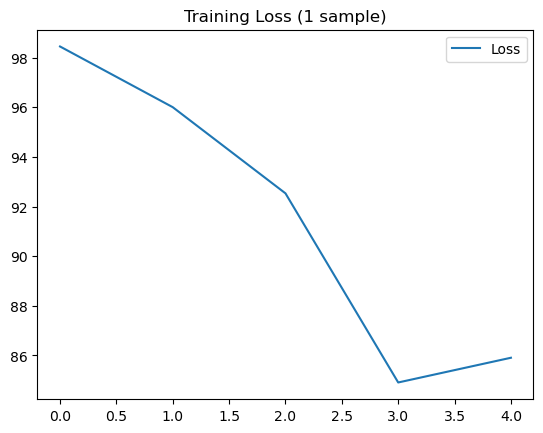

In [30]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# === Step 1: Load COVAREP file ===
covarep_path = "/Users/yubeiming/Depression/300_P/300_COVAREP.csv"  # update path if needed
df = pd.read_csv(covarep_path)

# === Step 2: Try to identify the VUV column (voiced/unvoiced flag) ===
vuv_col = None
for col in df.columns:
    if set(df[col].unique()).issubset({0, 1}) and df[col].nunique() == 2:
        vuv_col = col
        break

if not vuv_col:
    raise ValueError("VUV column not found. Make sure your COVAREP file includes voiced/unvoiced info.")

# === Step 3: Keep only voiced frames ===
df_voiced = df[df[vuv_col] == 1].copy()

# Drop VUV column for training
df_voiced = df_voiced.drop(columns=[vuv_col], errors="ignore")

# === Step 4: Pad or trim to fixed length ===
T = 100  # fixed number of time steps
features = df_voiced.fillna(0).values

if features.shape[0] < T:
    padding = np.zeros((T - features.shape[0], features.shape[1]))
    features = np.vstack([features, padding])
else:
    features = features[:T]

# === Step 5: Normalize features ===
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# === Step 6: Reshape for LSTM (samples, time steps, features) ===
X = features_scaled.reshape(1, T, -1)
y = np.array([10])  # Dummy PHQ-8 label; replace with real score

# === Step 7: Build and train LSTM ===
model = Sequential([
    LSTM(64, input_shape=(T, X.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# === Step 8: Train ===
history = model.fit(X, y, epochs=5, batch_size=1, verbose=1)

# === Step 9: Plot training loss ===
plt.plot(history.history['loss'], label='Loss')
plt.title("Training Loss (1 sample)")
plt.legend()
plt.show()


In [34]:
import os
from glob import glob

root_path = "/Users/yubeiming/Depression"
print("Subfolders:")
print(glob(os.path.join(root_path, "*")))

# Try to print first few COVAREP files
covarep_files = glob(os.path.join(root_path, "*", "*_COVAREP.csv"))
print("\nDetected COVAREP files:")
print(covarep_files[:5])


Subfolders:
['/Users/yubeiming/Depression/361_P', '/Users/yubeiming/Depression/300_P', '/Users/yubeiming/Depression/344_P', '/Users/yubeiming/Depression/325_P', '/Users/yubeiming/Depression/321_P', '/Users/yubeiming/Depression/340_P', '/Users/yubeiming/Depression/304_P', '/Users/yubeiming/Depression/382_P', '/Users/yubeiming/Depression/365_P', '/Users/yubeiming/Depression/331_P', '/Users/yubeiming/Depression/350_P', '/Users/yubeiming/Depression/314_P', '/Users/yubeiming/Depression/375_P', '/Users/yubeiming/Depression/371_P', '/Users/yubeiming/Depression/310_P', '/Users/yubeiming/Depression/354_P', '/Users/yubeiming/Depression/335_P', '/Users/yubeiming/Depression/347_P', '/Users/yubeiming/Depression/326_P', '/Users/yubeiming/Depression/385_P', '/Users/yubeiming/Depression/362_P', '/Users/yubeiming/Depression/368_P', '/Users/yubeiming/Depression/303_P', '/Users/yubeiming/Depression/381_P', '/Users/yubeiming/Depression/366_P', '/Users/yubeiming/Depression/349_P', '/Users/yubeiming/Depress

In [36]:
import pandas as pd
import numpy as np
from glob import glob
import os

covarep_files = glob("/Users/yubeiming/Depression/*_P/*_COVAREP.csv")

X_all = []
y_all = []

T = 100  # Fixed number of time steps

for file_path in covarep_files:
    pid = os.path.basename(file_path).split("_")[0]  # e.g., '300'

    if pid not in phq_dict:
        print(f"❌ No PHQ score for participant {pid}")
        continue

    df = pd.read_csv(file_path)

    # Try to detect VUV column
    vuv_col = None
    for col in df.columns:
        if set(df[col].unique()).issubset({0, 1}) and df[col].nunique() == 2:
            vuv_col = col
            break

    if vuv_col is None:
        print(f"⚠️ VUV column not found in {pid}, skipping.")
        continue

    df_voiced = df[df[vuv_col] == 1].drop(columns=[vuv_col], errors="ignore")
    df_voiced = df_voiced.fillna(0)

    # Pad or trim to T frames
    if len(df_voiced) < T:
        padding = np.zeros((T - len(df_voiced), df_voiced.shape[1]))
        arr = np.vstack([df_voiced.values, padding])
    else:
        arr = df_voiced.values[:T]

    X_all.append(arr)
    y_all.append(phq_dict[pid])

# Convert to numpy arrays
X_all = np.array(X_all)
y_all = np.array(y_all)

print("✅ Loaded samples:", X_all.shape[0])
print("📐 Shape of X:", X_all.shape)
print("🎯 Shape of y:", y_all.shape)


❌ No PHQ score for participant 344
❌ No PHQ score for participant 325
❌ No PHQ score for participant 321
❌ No PHQ score for participant 340
❌ No PHQ score for participant 304
❌ No PHQ score for participant 382
❌ No PHQ score for participant 331
❌ No PHQ score for participant 350
❌ No PHQ score for participant 375
❌ No PHQ score for participant 371
❌ No PHQ score for participant 310
❌ No PHQ score for participant 335
❌ No PHQ score for participant 347
❌ No PHQ score for participant 326
❌ No PHQ score for participant 385
❌ No PHQ score for participant 362
❌ No PHQ score for participant 368
❌ No PHQ score for participant 303
❌ No PHQ score for participant 381
❌ No PHQ score for participant 366
❌ No PHQ score for participant 322
❌ No PHQ score for participant 328
❌ No PHQ score for participant 343
❌ No PHQ score for participant 317
❌ No PHQ score for participant 376
❌ No PHQ score for participant 338
❌ No PHQ score for participant 353
❌ No PHQ score for participant 357
❌ No PHQ score for p

In [8]:
import pandas as pd

# Load the file with PHQ8_Score
df = pd.read_csv("/Users/yubeiming/combined_PHQ8_scores.csv")

# Add binary label
df["PHQ8_Binary"] = (df["PHQ8_Score"] >= 10).astype(int)

# Save to new file
df.to_csv("/Users/yubeiming/combined_PHQ8_binary.csv", index=False)


Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4750 - loss: 0.6695 - val_accuracy: 0.2500 - val_loss: 0.7613
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9548 - loss: 0.5089 - val_accuracy: 0.2500 - val_loss: 0.7623
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8345 - loss: 0.5772 - val_accuracy: 0.2500 - val_loss: 0.7538
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8798 - loss: 0.4952 - val_accuracy: 0.2500 - val_loss: 0.7505
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.4714 - val_accuracy: 0.2500 - val_loss: 0.7530
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9298 - loss: 0.4251 - val_accuracy: 0.2500 - val_loss: 0.7610
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9298 - loss: 0.3778 - val_accuracy: 0.2500 - val_loss: 0.7723
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9298 - loss: 0.3649 - val_accuracy: 0.2500 - val_loss: 0.7849
Epoch 9/50


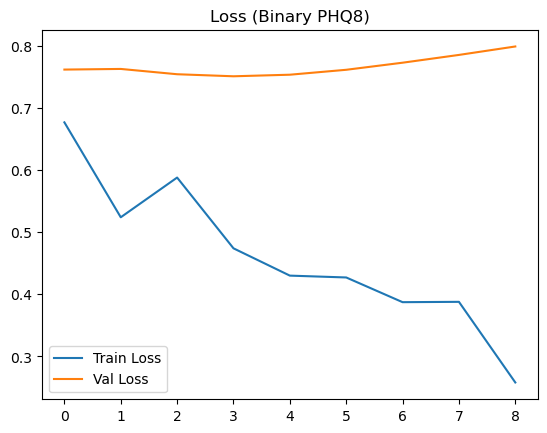

✅ Test Accuracy: 0.25


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Normalize
nsamples, timesteps, nfeatures = X_all.shape
X_flat = X_all.reshape(-1, nfeatures)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat).reshape(nsamples, timesteps, nfeatures)

# Convert y_all to binary
y_binary = (y_all >= 10).astype(int)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

# Model
model = Sequential([
    LSTM(64, input_shape=(timesteps, nfeatures)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=4,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss (Binary PHQ8)")
plt.legend()
plt.show()

# Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {acc:.2f}")


Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4058 - loss: 0.7420 - val_accuracy: 0.4667 - val_loss: 0.7118
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5598 - loss: 0.6986 - val_accuracy: 0.6000 - val_loss: 0.6963
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5128 - loss: 0.6080 - val_accuracy: 0.6667 - val_loss: 0.6782
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6923 - loss: 0.5250 - val_accuracy: 0.6667 - val_loss: 0.6696
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7024 - loss: 0.5693 - val_accuracy: 0.5333 - val_loss: 0.6706
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7628 - loss: 0.5031 - val_accuracy: 0.6333 - val_loss: 0.6499
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7538 - loss: 0.5019 - val_accuracy: 0.6333 - val_loss: 0.6312
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8479 - loss: 0.4681 - val_accuracy: 0.6667 - val_loss: 0.6275
Epo

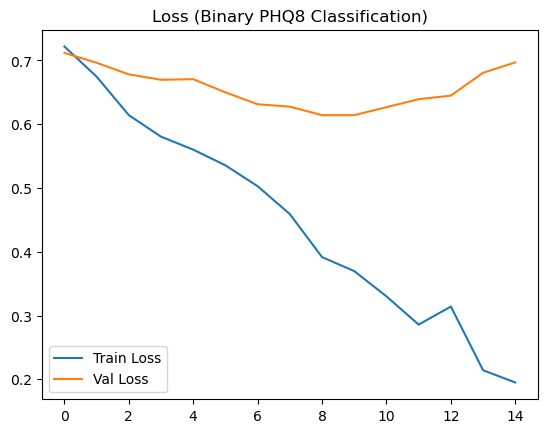

In [44]:
import os
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# === Step 1: Load PHQ-8 binary labels ===
label_path = "/Users/yubeiming/combined_PHQ8_scores.csv"
labels_df = pd.read_csv(label_path)
labels_df["Participant_ID"] = labels_df["Participant_ID"].astype(str)
labels_df["PHQ8_Binary"] = (labels_df["PHQ8_Score"] >= 10).astype(int)
phq_dict = dict(zip(labels_df["Participant_ID"], labels_df["PHQ8_Binary"]))

# === Step 2: Load and process COVAREP features ===
T = 100  # fixed time steps
X_all, y_all = [], []
covarep_files = glob("/Users/yubeiming/Depression/*_P/*_COVAREP.csv")

for file_path in covarep_files:
    pid = os.path.basename(file_path).split("_")[0]
    if pid not in phq_dict:
        continue

    df = pd.read_csv(file_path)
    vuv_col = next((col for col in df.columns if set(df[col].unique()).issubset({0, 1}) and df[col].nunique() == 2), None)
    if vuv_col is None: continue

    df_voiced = df[df[vuv_col] == 1].drop(columns=[vuv_col], errors="ignore").fillna(0)
    if len(df_voiced) < T:
        pad = np.zeros((T - len(df_voiced), df_voiced.shape[1]))
        arr = np.vstack([df_voiced.values, pad])
    else:
        arr = df_voiced.values[:T]

    X_all.append(arr)
    y_all.append(phq_dict[pid])

X_all = np.array(X_all)
y_all = np.array(y_all)

# === Step 3: Normalize and split ===
nsamples, timesteps, nfeatures = X_all.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all.reshape(-1, nfeatures)).reshape(nsamples, timesteps, nfeatures)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42)
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(enumerate(cw))

# === Step 4: Build and train LSTM ===
model = Sequential([
    LSTM(32, input_shape=(timesteps, nfeatures)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=4,
                    validation_data=(X_test, y_test),
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                    class_weight=cw_dict, verbose=1)

# === Step 5: Evaluation ===
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {acc:.2f}")

# === Step 6: Loss Curve ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss (Binary PHQ8 Classification)")
plt.legend()
plt.show()


In [1]:
import pandas as pd

# Load the three CSV files
train_df = pd.read_csv("/Users/yubeiming/train_split_Depression_AVEC2017.csv")
dev_df = pd.read_csv("/Users/yubeiming/dev_split_Depression_AVEC2017.csv")
test_df = pd.read_csv("/Users/yubeiming/full_test_split.csv")

# Combine all three
combined_df = pd.concat([train_df, dev_df, test_df], ignore_index=True)

# Keep only the columns of interest
columns_of_interest = ["Participant_ID", "PHQ8_Binary"]
combined_df = combined_df[columns_of_interest]

# Drop rows with missing PHQ8_Binary
combined_df = combined_df.dropna(subset=["PHQ8_Binary"])

# Save to CSV
combined_df.to_csv("combined_PHQ8_binary.csv", index=False)

print("✅ Combined dataset saved to 'combined_PHQ8_binary.csv'")
print(f"Total valid participants: {len(combined_df)}")


✅ Combined dataset saved to 'combined_PHQ8_binary.csv'
Total valid participants: 142


In [14]:
sample_path = "/Users/yubeiming/Depression/300_P/300_COVAREP.csv"
df = pd.read_csv(sample_path)
print("COVAREP columns:", df.columns.tolist())


COVAREP columns: ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '0.10', '-9.3103', '2.0175', '0.22462', '0.22488', '-0.10969', '0.038833', '0.135', '0.4781', '-0.006263', '-0.21851', '-0.30289', '0.13218', '0.11002', '0.07417', '0.036744', '0.070742', '-0.014848', '-0.09472', '0.032859', '0.032926', '0.036399', '0.00094644', '-0.015', '0.10935', '-0.028545', '0.11', '0.12', '0.13', '0.14', '0.15', '0.16', '0.17', '0.18', '0.19', '0.20', '0.21', '0.22', '0.23', '0.24', '0.25', '0.26', '0.27', '0.28', '0.29', '0.30', '0.31', '0.32', '0.33', '0.34', '0.35', '0.36', '0.37', '0.38', '0.39', '0.40', '0.41', '0.42', '0.43', '0.44', '0.45', '0.46', '0.47', '0.48']


In [28]:
# Define expected COVAREP feature names (excluding the time column)
feature_names = [
    "F0", "VUV", "NAQ", "QOQ", "H1H2", "PSP", "MDQ", "peakSlope", "Rd", "Rd_conf"
] + [f"MCEP_{i}" for i in range(25)] \
  + [f"HMPDM_{i}" for i in range(25)] \
  + [f"HMPDD_{i}" for i in range(13)]

# Include time/frame index as first column
full_column_names = ["Time"] + feature_names  # Now length = 74

# Load and assign column names
df = pd.read_csv("/Users/yubeiming/Depression/300_P/300_COVAREP.csv", header=None)
df.columns = full_column_names


In [30]:
import os
import pandas as pd
from glob import glob

# Step 1: Define correct column names (total = 74, including 'Time')
feature_names = [
    "F0", "VUV", "NAQ", "QOQ", "H1H2", "PSP", "MDQ", "peakSlope", "Rd", "Rd_conf"
] + [f"MCEP_{i}" for i in range(25)] \
  + [f"HMPDM_{i}" for i in range(25)] \
  + [f"HMPDD_{i}" for i in range(13)]

full_column_names = ["Time"] + feature_names  # 74 columns total

# Step 2: Set root directory for COVAREP files
root_dir = "/Users/yubeiming/Depression"  # Change if needed
covarep_files = glob(os.path.join(root_dir, "*_P", "*_COVAREP.csv"))

print(f"🔍 Found {len(covarep_files)} COVAREP files.\n")

# Step 3: Check and process each file
for file_path in sorted(covarep_files):
    pid = os.path.basename(file_path).split("_")[0]
    
    try:
        df = pd.read_csv(file_path, header=None)

        # Check shape
        if df.shape[1] != 74:
            print(f"❌ File {pid}_COVAREP.csv has {df.shape[1]} columns (expected 74). Skipping.")
            continue
        
        # Assign column names
        df.columns = full_column_names

        # Optional: Check for missing values
        missing = df.isnull().sum().sum()
        if missing > 0:
            print(f"⚠️  File {pid}_COVAREP.csv has {missing} missing values.")
        else:
            print(f"✅ File {pid}_COVAREP.csv loaded successfully with shape {df.shape}.")

        # Optional: Drop Time column if not needed
        df = df.drop(columns=["Time"])

        # You can now use df for modeling or save it
        # df.to_csv(f"{pid}_cleaned.csv", index=False)

    except Exception as e:
        print(f"❌ Error reading file {file_path}: {e}")


🔍 Found 184 COVAREP files.

✅ File 300_COVAREP.csv loaded successfully with shape (64851, 74).
✅ File 301_COVAREP.csv loaded successfully with shape (82389, 74).
✅ File 302_COVAREP.csv loaded successfully with shape (75879, 74).
✅ File 303_COVAREP.csv loaded successfully with shape (98529, 74).
✅ File 304_COVAREP.csv loaded successfully with shape (79260, 74).
✅ File 305_COVAREP.csv loaded successfully with shape (170400, 74).
✅ File 306_COVAREP.csv loaded successfully with shape (85809, 74).
✅ File 310_COVAREP.csv loaded successfully with shape (84489, 74).
✅ File 311_COVAREP.csv loaded successfully with shape (78561, 74).
✅ File 312_COVAREP.csv loaded successfully with shape (78999, 74).
✅ File 314_COVAREP.csv loaded successfully with shape (154671, 74).
✅ File 316_COVAREP.csv loaded successfully with shape (86901, 74).
✅ File 317_COVAREP.csv loaded successfully with shape (80490, 74).
✅ File 318_COVAREP.csv loaded successfully with shape (58839, 74).
✅ File 319_COVAREP.csv loaded su

In [34]:
# Step 1: Load all PHQ labels
phq_train = pd.read_csv("train_split_Depression_AVEC2017.csv")
phq_dev = pd.read_csv("dev_split_Depression_AVEC2017.csv")
phq_test = pd.read_csv("full_test_split.csv")

# Standardize and combine
label_df = pd.concat([phq_train, phq_dev, phq_test], ignore_index=True)
label_df.columns = [col.strip() for col in label_df.columns]  # clean whitespace
label_df["Participant_ID"] = label_df["Participant_ID"].astype(str)
label_df = label_df.drop_duplicates(subset="Participant_ID")

# Optional: keep only binary label
label_df = label_df[["Participant_ID", "PHQ_Binary"]]


In [51]:
import numpy as np

# Example: build dataset with per-participant mean values
all_features = []
all_labels = []

for file_path in sorted(covarep_files):
    pid = os.path.basename(file_path).split("_")[0]
    df = pd.read_csv(file_path, header=None)
    df.columns = full_column_names
    df = df.drop(columns=["Time"])
    
    if pid in label_df["Participant_ID"].values:
        # Compute mean across all time steps
        row = df.mean().values
        all_features.append(row)
        
        # Get label
        label = label_df.loc[label_df["Participant_ID"] == pid, "PHQ_Binary"].values[0]
        all_labels.append(label)

X = np.array(all_features)
y = np.array(all_labels)


print("✅ Final dataset shape:", X.shape)
print("🎯 Labels shape:", y.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'replace'

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ✅ Step 1: Load labels
label_df = pd.read_csv("combined_PHQ8_binary.csv")
label_dict = dict(zip(label_df["Participant_ID"].astype(str), label_df["PHQ8_Binary"]))

# ✅ Step 2: Load features from all COVAREP files
folder_path = "Depression"
X, y = [], []

for pid in label_dict:
    covarep_path = os.path.join(folder_path, f"{pid}_P", f"{pid}_COVAREP.csv")
    if os.path.exists(covarep_path):
        df = pd.read_csv(covarep_path)
        if df.shape[1] != 74:
            print(f"❌ Skipping {pid}: unexpected number of columns {df.shape[1]}")
            continue
        df = df.drop(columns=df.columns[0])  # drop timestamp column
        df = df.fillna(0)
        X.append(df.to_numpy()[:100])  # take first 100 frames
        y.append(label_dict[pid])
    else:
        print(f"❌ File not found: {covarep_path}")

X = np.array(X)
y = np.array(y)

# ✅ Step 3: Normalize
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[2])).reshape(X.shape)

# ✅ Step 4: Dataset setup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class COVAREPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(COVAREPDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(COVAREPDataset(X_test, y_test), batch_size=16)

# ✅ Step 5: Define model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return self.sigmoid(out)

model = LSTMModel(input_size=X.shape[2])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ✅ Step 6: Training
for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb).squeeze()
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# ✅ Step 7: Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb).squeeze()
        predicted = (pred > 0.5).float()
        correct += (predicted == yb).sum().item()
        total += yb.size(0)
print(f"Test Accuracy: {correct / total:.2f}")


In [44]:
import pandas as pd

df = pd.read_csv("combined_PHQ8_binary.csv")
print(df.columns)


Index(['Participant_ID', 'PHQ8_Binary'], dtype='object')


In [58]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time

# 1. Define COVAREP feature names
feature_names = [
    "F0", "VUV", "NAQ", "QOQ", "H1H2", "PSP", "MDQ", "peakSlope", "Rd", "Rd_conf"
] + [f"MCEP_{i}" for i in range(25)] + [f"HMPDM_{i}" for i in range(25)] + [f"HMPDD_{i}" for i in range(13)]

# 2. Load labels
label_df = pd.read_csv("combined_PHQ8_binary.csv")
label_dict = dict(zip(label_df["Participant_ID"].astype(str), label_df["PHQ8_Binary"]))

# 3. Load features
data_dir = "Depression"
X = []
y = []

for folder in os.listdir(data_dir):
    pid = folder.split("_")[0]
    covarep_path = os.path.join(data_dir, folder, f"{pid}_COVAREP.csv")
    if not os.path.isfile(covarep_path) or pid not in label_dict:
        continue

    df = pd.read_csv(covarep_path, header=None)

    # Drop extra column if needed
    if df.shape[1] == 74:
        df = df.drop(columns=[0])

    if df.shape[1] != 73:
        print(f"⚠️ Skipping {pid}: column mismatch ({df.shape[1]} vs 73)")
        continue

    df.columns = feature_names

    # Remove rows with inf, NaN
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    if df.shape[0] < 100:
        continue  # Skip if too few frames

    # Take the first 100 frames
    trimmed = df.iloc[:100].values
    X.append(trimmed)
    y.append(label_dict[pid])

X = np.array(X)
y = np.array(y)
print(f"✅ Final dataset shape: {X.shape}")
print(f"🎯 Labels shape: {y.shape}")

# 4. Scale features
scaler = StandardScaler()
X = X.reshape(-1, X.shape[-1])
X = scaler.fit_transform(X)
X = X.reshape(-1, 100, 73)

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 6. Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# 7. Define simple LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=73, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return torch.sigmoid(self.fc(h_n[-1]))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleLSTM().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 8. Train the model
EPOCHS = 10
for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    duration = time.time() - start_time
    eta = duration * (EPOCHS - epoch - 1)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}, Time: {duration:.2f}s, ETA: {eta:.2f}s")

# 9. Evaluate
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x).cpu().numpy()
        predicted = (outputs > 0.5).astype(int).flatten()
        correct += (predicted == batch_y.numpy()).sum()
        total += batch_y.size(0)

print(f"✅ Test Accuracy: {correct / total:.2%}")


✅ Final dataset shape: (139, 100, 73)
🎯 Labels shape: (139,)
Epoch 1/10, Loss: 4.7234, Time: 0.13s, ETA: 1.20s
Epoch 2/10, Loss: 4.4573, Time: 0.05s, ETA: 0.43s
Epoch 3/10, Loss: 4.2385, Time: 0.06s, ETA: 0.39s
Epoch 4/10, Loss: 3.9673, Time: 0.05s, ETA: 0.32s
Epoch 5/10, Loss: 3.7060, Time: 0.05s, ETA: 0.26s
Epoch 6/10, Loss: 3.3612, Time: 0.05s, ETA: 0.20s
Epoch 7/10, Loss: 3.0690, Time: 0.05s, ETA: 0.14s
Epoch 8/10, Loss: 2.7331, Time: 0.05s, ETA: 0.10s
Epoch 9/10, Loss: 2.4163, Time: 0.05s, ETA: 0.05s
Epoch 10/10, Loss: 2.0250, Time: 0.05s, ETA: 0.00s
✅ Test Accuracy: 75.00%


In [60]:
pip install transformers datasets torchaudio librosa


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 26.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.29.3
    Uninstalling huggingface-hub-0.29.3:
      Successfully uninstalled huggingface-hub-0.29.3
Note: you may need to restart the kernel to use updated packages.


In [86]:
import os
import pandas as pd
import re

# Step 1: Set the path to your Depression audio folder
audio_dir = "Depression"  # or the full path if needed

# Step 2: Get all WAV files
wav_files = [f for f in os.listdir(audio_dir) if f.endswith("_AUDIO.wav")]

# Step 3: Build a DataFrame with extracted Participant_ID
def extract_id(filename):
    match = re.match(r"(\d+)_AUDIO\.wav", filename)
    return int(match.group(1)) if match else None

data = {
    "path": [os.path.join(audio_dir, f) for f in wav_files],
    "Participant_ID": [extract_id(f) for f in wav_files]
}

df_audio = pd.DataFrame(data)

# Step 4: Load the PHQ8 label file
labels = pd.read_csv("combined_PHQ8_binary.csv")
labels["Participant_ID"] = labels["Participant_ID"].astype(int)

# Step 5: Merge audio paths with labels
df_merged = df_audio.merge(labels, on="Participant_ID", how="inner")

# Step 6: Save or view
df_merged.to_csv("final_audio_with_labels.csv", index=False)
print(f"✅ Final merged file saved with shape: {df_merged.shape}")
print(df_merged.head())


✅ Final merged file saved with shape: (0, 3)
Empty DataFrame
Columns: [path, Participant_ID, PHQ8_Binary]
Index: []


In [88]:
audio_ids = [extract_id(f) for f in wav_files]
print("🔊 Audio file Participant_IDs:", sorted(audio_ids))


🔊 Audio file Participant_IDs: []


In [90]:
print("📋 PHQ8 label Participant_IDs:", sorted(labels["Participant_ID"].unique()))


📋 PHQ8 label Participant_IDs: [302, 303, 304, 305, 307, 310, 312, 313, 315, 316, 317, 318, 319, 320, 321, 322, 324, 325, 326, 327, 328, 330, 331, 333, 335, 336, 338, 339, 340, 341, 343, 344, 345, 346, 347, 348, 350, 351, 352, 353, 355, 356, 357, 358, 360, 362, 363, 364, 366, 367, 368, 369, 370, 371, 372, 374, 375, 376, 377, 379, 380, 381, 382, 383, 385, 386, 388, 389, 390, 391, 392, 393, 395, 397, 400, 401, 402, 403, 404, 406, 409, 412, 413, 414, 415, 416, 417, 418, 419, 420, 422, 423, 425, 426, 427, 428, 429, 430, 433, 434, 436, 437, 439, 440, 441, 443, 444, 445, 446, 447, 448, 449, 451, 454, 455, 456, 457, 458, 459, 463, 464, 468, 471, 472, 473, 474, 475, 476, 477, 478, 479, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492]


In [94]:
wav_files = glob("/Users/yubeiming/Depression/*_P/*_AUDIO.wav")


In [96]:
import os
import re

def extract_id(path):
    filename = os.path.basename(path)
    match = re.match(r"(\d+)_AUDIO\.wav", filename)
    return int(match.group(1)) if match else None


In [98]:
audio_ids = [extract_id(f) for f in wav_files]
print("✅ Extracted IDs:", audio_ids[:5])


✅ Extracted IDs: [475, 386, 361, 492, 414]


In [100]:
import os
import pandas as pd
from glob import glob
import re

# Step 1: Paths
audio_root = "/Users/yubeiming/Depression"
label_path = "/Users/yubeiming/combined_PHQ8_binary.csv"

# Step 2: Load label file
labels = pd.read_csv(label_path)
labels["Participant_ID"] = labels["Participant_ID"].astype(int)

# Step 3: Get all audio file paths
wav_files = glob(os.path.join(audio_root, "*_P", "*_AUDIO.wav"))

# Step 4: Extract participant ID from filename
def extract_id(path):
    filename = os.path.basename(path)
    match = re.match(r"(\d+)_AUDIO\.wav", filename)
    return int(match.group(1)) if match else None

data = []
for wav_path in wav_files:
    pid = extract_id(wav_path)
    if pid in labels["Participant_ID"].values:
        label = labels.loc[labels["Participant_ID"] == pid, "PHQ8_Binary"].values[0]
        data.append({"path": wav_path, "Participant_ID": pid, "PHQ8_Binary": label})

# Step 5: Create final DataFrame
df = pd.DataFrame(data)
print(f"✅ Final dataset shape: {df.shape}")
print(df.head())

# Optional: Save it for Hugging Face Dataset loading
df.to_csv("wav2vec2_binary_dataset.csv", index=False)


✅ Final dataset shape: (139, 3)
                                              path  Participant_ID  \
0  /Users/yubeiming/Depression/475_P/475_AUDIO.wav             475   
1  /Users/yubeiming/Depression/386_P/386_AUDIO.wav             386   
2  /Users/yubeiming/Depression/492_P/492_AUDIO.wav             492   
3  /Users/yubeiming/Depression/414_P/414_AUDIO.wav             414   
4  /Users/yubeiming/Depression/344_P/344_AUDIO.wav             344   

   PHQ8_Binary  
0          0.0  
1          1.0  
2          0.0  
3          1.0  
4          1.0  


In [106]:
import os
import pandas as pd

# Your final DataFrame, assumed already created with columns: ['path', 'Participant_ID', 'PHQ8_Binary']
# Let's assume it's called `df`

output_path = "wav2vec2_binary_dataset.csv"

# ✅ Optional: Save for later use
if not os.path.exists(output_path):
    df.to_csv(output_path, index=False)
    print(f"✅ Dataset saved to {output_path}")
else:
    print(f"⚠️ File {output_path} already exists. Loading it instead.")
    df = pd.read_csv(output_path)

# 🔍 Check
print(f"✅ Final dataset shape: {df.shape}")
print(df.head())


⚠️ File wav2vec2_binary_dataset.csv already exists. Loading it instead.
✅ Final dataset shape: (139, 3)
                                              path  Participant_ID  \
0  /Users/yubeiming/Depression/475_P/475_AUDIO.wav             475   
1  /Users/yubeiming/Depression/386_P/386_AUDIO.wav             386   
2  /Users/yubeiming/Depression/492_P/492_AUDIO.wav             492   
3  /Users/yubeiming/Depression/414_P/414_AUDIO.wav             414   
4  /Users/yubeiming/Depression/344_P/344_AUDIO.wav             344   

   PHQ8_Binary  
0          0.0  
1          1.0  
2          0.0  
3          1.0  
4          1.0  


In [16]:
import os
import pandas as pd
import torch
import librosa
from datasets import Dataset
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import torchaudio


# ====== Step 1: Load combined PHQ8 Binary File ======
label_df = pd.read_csv("combined_PHQ8_binary.csv")

# ====== Step 2: Match Audio File Paths ======
AUDIO_DIR = "/Users/yubeiming/Depression"  # Your root folder of audio files

def get_audio_path(participant_id):
    return os.path.join(AUDIO_DIR, f"{participant_id}_P", f"{participant_id}_AUDIO.wav")

label_df["path"] = label_df["Participant_ID"].apply(get_audio_path)
label_df = label_df[label_df["path"].apply(os.path.exists)].reset_index(drop=True)

# ====== Step 3: Prepare Hugging Face Dataset ======
dataset = Dataset.from_pandas(label_df[["path", "PHQ8_Binary"]])

# ====== Step 4: Load Processor ======
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

# ====== Step 5: Preprocessing ======
def preprocess(example):
    speech_array, _ = torchaudio.load(example["path"])
    speech_array = torchaudio.functional.resample(speech_array, orig_freq=_, new_freq=16000)

    inputs = processor(
        speech_array.squeeze().numpy(),
        sampling_rate=16000,
        return_tensors="pt",
        padding="max_length",
        max_length=16000
    )

    return {
        "input_values": inputs.input_values.squeeze(0),
        # "attention_mask": inputs.attention_mask.squeeze(0),  # 🔴 REMOVE THIS LINE
        "labels": int(example["PHQ8_Binary"])
    }


dataset = dataset.map(preprocess)

# ====== Step 6: Train-Test Split ======
train_test = dataset.train_test_split(test_size=0.2)
train_ds = train_test["train"]
eval_ds = train_test["test"]

# ====== Step 7: Load Model ======
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=2,
    gradient_checkpointing=True,
    problem_type="single_label_classification"
)

# ====== Step 8: Define Trainer ======
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./wav2vec2_phq8_binary",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    logging_dir="./logs"
)

def collate_fn(batch):
    input_values = torch.stack([x["input_values"] for x in batch])
    attention_mask = torch.stack([x["attention_mask"] for x in batch])
    labels = torch.tensor([x["labels"] for x in batch])
    return {"input_values": input_values, "attention_mask": attention_mask, "labels": labels}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,  # If batching fails, add this
)


# ====== Step 9: Train ======
trainer.train()

# ====== Step 10: Save Final Model ======
model.save_pretrained("./wav2vec2_phq8_binary_model")
processor.save_pretrained("./wav2vec2_phq8_binary_model")


/opt/anaconda3/lib/python3.12/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Map:   0%|          | 0/139 [00:00<?, ? examples/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'train_dataset' is not defined

In [10]:
pip install torchaudio

Note: you may need to restart the kernel to use updated packages.


In [50]:
import os
import pandas as pd
import torch
import torchaudio
from datasets import Dataset
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    Trainer,
    TrainingArguments,
    default_data_collator
)

# ====== Step 1: Load Labels ======
label_df = pd.read_csv("combined_PHQ8_binary.csv")

# ====== Step 2: Match Audio File Paths ======
AUDIO_DIR = "/Users/yubeiming/Depression"

def get_audio_path(participant_id):
    return os.path.join(AUDIO_DIR, f"{participant_id}_P", f"{participant_id}_AUDIO.wav")

label_df["path"] = label_df["Participant_ID"].apply(get_audio_path)
label_df = label_df[label_df["path"].apply(os.path.exists)].reset_index(drop=True)

# ====== Step 3: Prepare Hugging Face Dataset ======
dataset = Dataset.from_pandas(label_df[["path", "PHQ8_Binary"]])

# ====== Step 4: Load Processor ======
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

# ====== Step 5: Preprocessing ======
def preprocess(example):
    speech_array, sampling_rate = torchaudio.load(example["path"])
    speech_array = torchaudio.functional.resample(speech_array, orig_freq=sampling_rate, new_freq=16000)

    inputs = processor(
    speech_array.squeeze().numpy(),
    sampling_rate=16000,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=16000 * 5  # e.g., 5 seconds = 80,000 samples
)



    return {
        "input_values": inputs.input_values.squeeze(0),
        "labels": int(example["PHQ8_Binary"])
    }

dataset = dataset.map(preprocess)

# ====== Step 6: Train-Test Split ======
train_test = dataset.train_test_split(test_size=0.2)
train_ds = train_test["train"]
eval_ds = train_test["test"]

# ====== Step 7: Load Model ======
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=2,
    gradient_checkpointing=True,
    problem_type="single_label_classification"
)

# ====== Step 8: Training Arguments ======
training_args = TrainingArguments(
    output_dir="./wav2vec2_phq8_binary",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=8,
    logging_dir="./logs"
)

# ====== Step 9: Trainer ======
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=default_data_collator,
    tokenizer=processor
)

# ====== Step 10: Train ======
trainer.train()

# ====== Step 11: Save Final Model ======
model.save_pretrained("./wav2vec2_phq8_binary_model")
processor.save_pretrained("./wav2vec2_phq8_binary_model")


/opt/anaconda3/lib/python3.12/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Map:   0%|          | 0/139 [00:00<?, ? examples/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gp/6yrz6lk90p9fh8sy2bz0lllc0000gn/T/ipykernel_80196/2175590047.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


[]

In [32]:
trainer.evaluate()


{'eval_loss': 0.5657823085784912,
 'eval_runtime': 2.0816,
 'eval_samples_per_second': 13.451,
 'eval_steps_per_second': 3.363,
 'epoch': 5.0}

In [44]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    return {
        "accuracy": acc["accuracy"],
        "f1": f1["f1"]
    }


In [46]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics
)


In [48]:
trainer.train()
trainer.evaluate()

Step,Training Loss


{'eval_loss': 0.71713787317276,
 'eval_accuracy': 0.6071428571428571,
 'eval_f1': 0.45873015873015877,
 'eval_runtime': 4.9144,
 'eval_samples_per_second': 5.698,
 'eval_steps_per_second': 1.424,
 'epoch': 10.0}

/opt/anaconda3/lib/python3.12/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Map:   0%|          | 0/139 [00:00<?, ? examples/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gp/6yrz6lk90p9fh8sy2bz0lllc0000gn/T/ipykernel_80196/1084028848.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,0.591600
20,0.667400
30,0.686200
40,0.597400
50,0.652600
60,0.664000
70,0.627400
80,0.595800
90,0.770300
100,0.580400


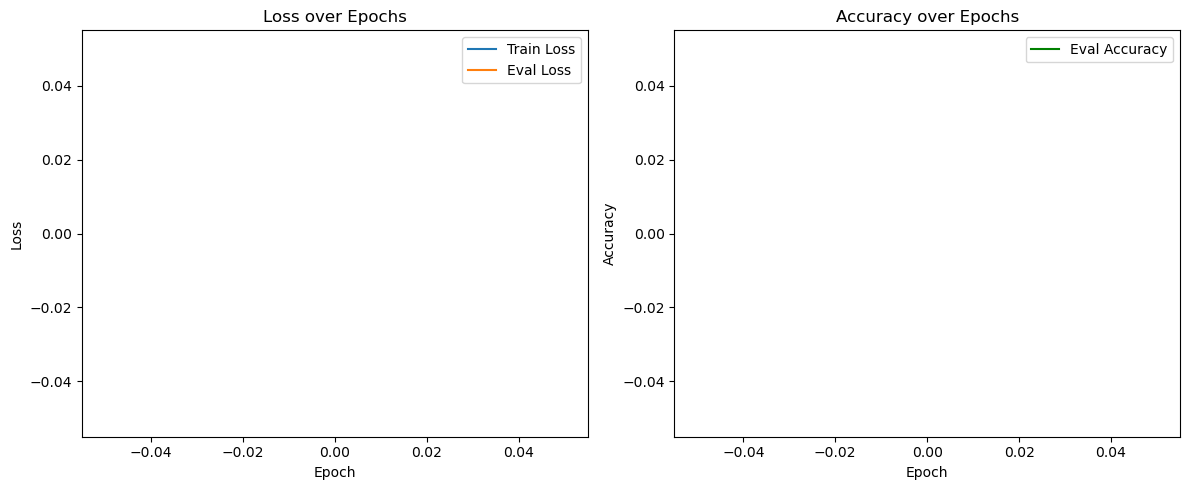

In [74]:
import os
import pandas as pd
import torch
import torchaudio
from datasets import Dataset
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import evaluate
import numpy as np
import matplotlib.pyplot as plt

# ====== Step 1: Load Labels ======
label_df = pd.read_csv("combined_PHQ8_binary.csv")

# ====== Step 2: Match Audio File Paths ======
AUDIO_DIR = "/Users/yubeiming/Depression"

def get_audio_path(participant_id):
    return os.path.join(AUDIO_DIR, f"{participant_id}_P", f"{participant_id}_AUDIO.wav")

label_df["path"] = label_df["Participant_ID"].apply(get_audio_path)
label_df = label_df[label_df["path"].apply(os.path.exists)].reset_index(drop=True)

# ====== Step 3: Prepare Dataset ======
dataset = Dataset.from_pandas(label_df[["path", "PHQ8_Binary"]])

# ====== Step 4: Load Processor ======
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

# ====== Step 5: Preprocessing ======
def preprocess(example):
    try:
        # Load and resample
        speech_array, sampling_rate = torchaudio.load(example["path"])
        if sampling_rate != 16000:
            speech_array = torchaudio.functional.resample(speech_array, orig_freq=sampling_rate, new_freq=16000)

        MAX_INPUT_LENGTH = 16000 * 20  # up to 20 seconds

        inputs = processor(
            speech_array.squeeze().numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=MAX_INPUT_LENGTH
        )

        return {
            "input_values": inputs["input_values"].squeeze(0),
            "labels": int(example["PHQ8_Binary"])
        }

    except Exception as e:
        print(f"[Error] Skipping file {example['path']} due to: {e}")
        return {
            "input_values": None,
            "labels": None
        }



dataset = dataset.map(preprocess)

# ====== Step 6: Train-Test Split ======
train_test = dataset.train_test_split(test_size=0.2)
train_ds = train_test["train"]
eval_ds = train_test["test"]

# ====== Step 7: Load Model ======
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=2,
    problem_type="single_label_classification",
    gradient_checkpointing=True
)

# ====== Step 8: Define Accuracy Metric ======
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

# ====== Step 9: TrainingArguments ======
training_args = TrainingArguments(
    output_dir="./wav2vec2_phq8_binary",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=10
)

# ====== Step 10: Data Collator ======
data_collator = DataCollatorWithPadding(tokenizer=processor)

# ====== Step 11: Trainer ======
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# ====== Step 12: Train ======
trainer.train()

# ====== Step 13: Save Model ======
model.save_pretrained("./wav2vec2_phq8_binary_model")
processor.save_pretrained("./wav2vec2_phq8_binary_model")

# ====== Step 14: Plot Accuracy and Loss ======
log_history = trainer.state.log_history

train_loss = [l["loss"] for l in log_history if "loss" in l]
eval_loss = [l["eval_loss"] for l in log_history if "eval_loss" in l]
eval_acc = [l["eval_accuracy"] for l in log_history if "eval_accuracy" in l]
epochs = list(range(1, len(eval_loss) + 1))

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss[:len(epochs)], label="Train Loss")
plt.plot(epochs, eval_loss, label="Eval Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_acc, label="Eval Accuracy", color="green")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import os
import pandas as pd
import torch
import torchaudio
from datasets import Dataset
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import evaluate
import numpy as np
import matplotlib.pyplot as plt

# ====== Step 1: Load Labels ======
label_df = pd.read_csv("combined_PHQ8_binary.csv")

# ====== Step 2: Match Audio File Paths ======
AUDIO_DIR = "/Users/yubeiming/Depression"

def get_audio_path(participant_id):
    return os.path.join(AUDIO_DIR, f"{participant_id}_P", f"{participant_id}_AUDIO.wav")

label_df["path"] = label_df["Participant_ID"].apply(get_audio_path)
label_df = label_df[label_df["path"].apply(os.path.exists)].reset_index(drop=True)

# ====== Step 3: Prepare Dataset ======
dataset = Dataset.from_pandas(label_df[["path", "PHQ8_Binary"]])

# ====== Step 4: Load Processor ======
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

# ====== Step 5: Preprocessing ======
def preprocess(example):
    try:
        # Load and resample
        speech_array, sampling_rate = torchaudio.load(example["path"])
        if sampling_rate != 16000:
            speech_array = torchaudio.functional.resample(speech_array, orig_freq=sampling_rate, new_freq=16000)

        MAX_INPUT_LENGTH = 16000 * 20  # up to 20 seconds

        inputs = processor(
            speech_array.squeeze().numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=MAX_INPUT_LENGTH
        )

        return {
            "input_values": inputs["input_values"].squeeze(0),
            "labels": int(example["PHQ8_Binary"])
        }

    except Exception as e:
        print(f"[Error] Skipping file {example['path']} due to: {e}")
        return {
            "input_values": None,
            "labels": None
        }



dataset = dataset.map(preprocess)

# ====== Step 6: Train-Test Split ======
train_test = dataset.train_test_split(test_size=0.2)
train_ds = train_test["train"]
eval_ds = train_test["test"]

# ====== Step 7: Load Model ======
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=2,
    problem_type="single_label_classification",
    gradient_checkpointing=True
)

# ====== Step 8: Define Accuracy Metric ======
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

# ====== Step 9: TrainingArguments ======
training_args = TrainingArguments(
    output_dir="./wav2vec2_phq8_binary",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=10
)

# ====== Step 10: Data Collator ======
data_collator = DataCollatorWithPadding(tokenizer=processor)

# ====== Step 11: Trainer ======
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# ====== Step 12: Train ======
trainer.train()

# ====== Step 13: Save Model ======
model.save_pretrained("./wav2vec2_phq8_binary_model")
processor.save_pretrained("./wav2vec2_phq8_binary_model")

# ====== Step 14: Plot Accuracy and Loss ======
log_history = trainer.state.log_history

train_loss = [l["loss"] for l in log_history if "loss" in l]
eval_loss = [l["eval_loss"] for l in log_history if "eval_loss" in l]
eval_acc = [l["eval_accuracy"] for l in log_history if "eval_accuracy" in l]
epochs = list(range(1, len(eval_loss) + 1))

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss[:len(epochs)], label="Train Loss")
plt.plot(epochs, eval_loss, label="Eval Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_acc, label="Eval Accuracy", color="green")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Map:   0%|          | 0/139 [00:00<?, ? examples/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gp/6yrz6lk90p9fh8sy2bz0lllc0000gn/T/ipykernel_80196/1084028848.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,0.591600
20,0.667400
30,0.686200
40,0.597400
50,0.652600
60,0.664000
70,0.627400


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# === Load Labels ===
label_df = pd.read_csv("combined_PHQ8_binary.csv")
COVAREP_DIR = "/Users/yubeiming/Depression"

# === Extract aggregated features (mean only) ===
def extract_covarep_mean(pid):
    path = os.path.join(COVAREP_DIR, f"{pid}_P", f"{pid}_COVAREP.csv")
    if not os.path.exists(path):
        return None
    try:
        df = pd.read_csv(path).drop(columns=["Time"], errors="ignore")
        df = df.apply(lambda col: pd.to_numeric(col, errors='coerce'))
        df = df.dropna(axis=1)
        return df.mean().to_dict()
    except Exception as e:
        print(f"[Error] {pid}: {e}")
        return None

# === Loop through participants and build feature set ===
features = []
for pid in tqdm(label_df["Participant_ID"]):
    feats = extract_covarep_mean(pid)
    if feats:
        feats["Participant_ID"] = pid
        features.append(feats)

feature_df = pd.DataFrame(features)
data = pd.merge(label_df, feature_df, on="Participant_ID")

# === Prepare tensors ===
X = data.drop(columns=["Participant_ID", "PHQ8_Binary"]).fillna(0).to_numpy(dtype=np.float32)
y = data["PHQ8_Binary"].to_numpy(dtype=np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Convert to tensors
X_train, X_test = torch.tensor(X_train), torch.tensor(X_test)
y_train, y_test = torch.tensor(y_train), torch.tensor(y_test)

# === Define simple MLP ===
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model = SimpleMLP(input_dim=X.shape[1])
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# === Train Loop ===
for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train)
    loss = loss_fn(logits, y_train)
    loss.backward()
    optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        preds = model(X_test).argmax(dim=1)
        acc = accuracy_score(y_test, preds)
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Val Acc: {acc:.3f}")

# === Final Report ===
print("\nFinal Report:\n", classification_report(y_test, preds))


In [88]:
import os
import pandas as pd
import torch
import torchaudio
from datasets import Dataset
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import evaluate
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# ===== Step 1: Load Labels =====
label_df = pd.read_csv("combined_PHQ8_binary.csv")
AUDIO_DIR = "/Users/yubeiming/Depression"
label_df["path"] = label_df["Participant_ID"].apply(
    lambda pid: os.path.join(AUDIO_DIR, f"{pid}_P", f"{pid}_AUDIO.wav")
)
label_df = label_df[label_df["path"].apply(os.path.exists)].reset_index(drop=True)
dataset = Dataset.from_pandas(label_df[["path", "PHQ8_Binary"]])

# ===== Step 2: Processor & VAD =====
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
vad = torchaudio.transforms.Vad(sample_rate=16000)

# ===== Step 3: Preprocessing =====
def preprocess(example):
    try:
        waveform, sr = torchaudio.load(example["path"])
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)
        waveform = vad(waveform)
        inputs = processor(
            waveform.squeeze().numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=16000 * 10  # 10 seconds
        )
        return {
            "input_values": inputs["input_values"].squeeze(0),
            "labels": int(example["PHQ8_Binary"])
        }
    except Exception as e:
        print(f"[Error] {example['path']}: {e}")
        return {"input_values": None, "labels": None}

dataset = dataset.map(preprocess).filter(lambda x: x["input_values"] is not None)

# ===== Step 4: Split =====
split = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = split["train"]
eval_ds = split["test"]

# ===== Step 5: Model =====
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=2,
    problem_type="single_label_classification"
)

# ===== Step 6: Metric =====
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

# ===== Step 7: Training Setup =====
training_args = TrainingArguments(
    output_dir="./wav2vec2_phq8_simple",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=processor,
    data_collator=DataCollatorWithPadding(tokenizer=processor),
    compute_metrics=compute_metrics
)

# ===== Step 8: Train =====
trainer.train()

# ===== Step 9: Save Model =====
model.save_pretrained("./wav2vec2_phq8_simple")
processor.save_pretrained("./wav2vec2_phq8_simple")

# ===== Step 10: Evaluation =====
print("\n✅ Final Evaluation Results:")
predictions = trainer.predict(eval_ds)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

print("Accuracy:", np.mean(preds == labels))
print("\nClassification Report:")
print(classification_report(labels, preds))
print("\nConfusion Matrix:")
print(confusion_matrix(labels, preds))


/opt/anaconda3/lib/python3.12/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gp/6yrz6lk90p9fh8sy2bz0lllc0000gn/T/ipykernel_80196/302738084.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,0.691500
20,0.675000
30,0.478900
40,0.602600
50,0.534100
60,0.681100
70,0.636900
80,0.438800
90,0.729800



✅ Final Evaluation Results:


Accuracy: 0.7

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        21
           1       0.00      0.00      0.00         9

    accuracy                           0.70        30
   macro avg       0.35      0.50      0.41        30
weighted avg       0.49      0.70      0.58        30


Confusion Matrix:
[[21  0]
 [ 9  0]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [90]:
import torch
import torch.nn as nn
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Config

# Custom model with class-weighted loss
class WeightedLossModel(Wav2Vec2ForSequenceClassification):
    def __init__(self, config, weight=None):
        super().__init__(config)
        self.weight = weight

    def forward(self, input_values=None, labels=None, **kwargs):
        outputs = super().forward(input_values=input_values, labels=None, **kwargs)
        logits = outputs.logits

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.weight.to(logits.device))
            loss = loss_fct(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}

# Example: Create a model using class weights
weights = torch.tensor([1.0, 3.0])  # Upweight class 1 (depressed)
config = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-base", num_labels=2)
model = WeightedLossModel.from_pretrained("facebook/wav2vec2-base", config=config, weight=weights)

# Save the new model locally
model.save_pretrained("./wav2vec2_phq8_weighted_model")


/opt/anaconda3/lib/python3.12/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of WeightedLossModel were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/opt/anaconda3/lib/python3.12/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

[VAD Error] Skipping /Users/yubeiming/Depression/354_P/354_AUDIO.wav due to: VAD removed too much content.
[VAD Error] Skipping /Users/yubeiming/Depression/365_P/365_AUDIO.wav due to: VAD removed too much content.
[VAD Error] Skipping /Users/yubeiming/Depression/431_P/431_AUDIO.wav due to: VAD removed too much content.
[VAD Error] Skipping /Users/yubeiming/Depression/432_P/432_AUDIO.wav due to: VAD removed too much content.
[VAD Error] Skipping /Users/yubeiming/Depression/427_P/427_AUDIO.wav due to: VAD removed too much content.
[VAD Error] Skipping /Users/yubeiming/Depression/437_P/437_AUDIO.wav due to: VAD removed too much content.
[VAD Error] Skipping /Users/yubeiming/Depression/441_P/441_AUDIO.wav due to: VAD removed too much content.
[VAD Error] Skipping /Users/yubeiming/Depression/475_P/475_AUDIO.wav due to: VAD removed too much content.
[VAD Error] Skipping /Users/yubeiming/Depression/479_P/479_AUDIO.wav due to: VAD removed too much content.
[VAD Error] Skipping /Users/yubeiming

Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gp/6yrz6lk90p9fh8sy2bz0lllc0000gn/T/ipykernel_80196/4145731355.py:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
5,0.699200
10,0.647700
15,0.547600
20,0.703000
25,0.639600
30,0.638400
35,0.509300
40,0.890700
45,0.616000
50,0.580500



✅ Final Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86        21
           1       0.00      0.00      0.00         7

    accuracy                           0.75        28
   macro avg       0.38      0.50      0.43        28
weighted avg       0.56      0.75      0.64        28



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


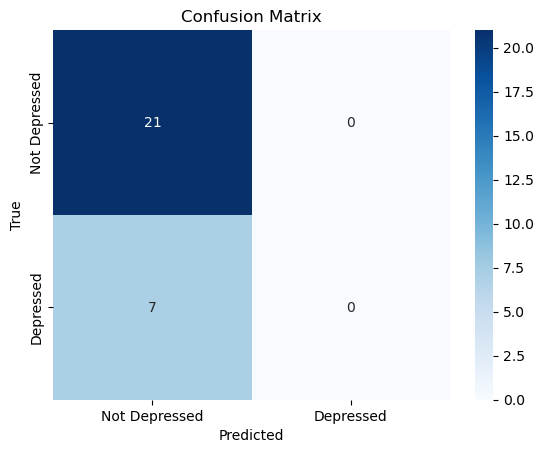

In [96]:
import os
import pandas as pd
import torch
import torchaudio
from datasets import Dataset
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Load Labels
label_df = pd.read_csv("combined_PHQ8_binary.csv")
label_df["Participant_ID"] = label_df["Participant_ID"].astype(str)

# Step 2: Match Audio File Paths
AUDIO_DIR = "/Users/yubeiming/Depression"

def get_audio_path(pid):
    return os.path.join(AUDIO_DIR, f"{pid}_P", f"{pid}_AUDIO.wav")

label_df["path"] = label_df["Participant_ID"].apply(get_audio_path)
label_df = label_df[label_df["path"].apply(os.path.exists)].reset_index(drop=True)

# Step 3: Build Dataset
dataset = Dataset.from_pandas(label_df[["path", "PHQ8_Binary"]])

# Step 4: Load Processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

# Step 5: Preprocessing
from torchaudio.transforms import Vad

vad = Vad(sample_rate=16000)

def preprocess(example):
    try:
        waveform, sr = torchaudio.load(example["path"])
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, orig_freq=sr, new_freq=16000)

        # Apply Voice Activity Detection to keep only speech segments
        vad_waveform = vad(waveform)

        # Skip files where VAD removed everything
        if vad_waveform.shape[1] < 16000:
            raise ValueError("VAD removed too much content.")

        inputs = processor(
            vad_waveform.squeeze().numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=16000 * 10  # still limit to 10 sec
        )

        return {
            "input_values": inputs["input_values"].squeeze(0),
            "labels": int(example["PHQ8_Binary"])
        }

    except Exception as e:
        print(f"[VAD Error] Skipping {example['path']} due to: {e}")
        return {"input_values": None, "labels": None}


dataset = dataset.map(preprocess).filter(lambda x: x["input_values"] is not None)

# Step 6: Train-Test Split
split = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = split["train"]
eval_ds = split["test"]

# Step 7: Load Model
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=2,
    problem_type="single_label_classification"
)

# Step 8: Training Arguments (no evaluation_strategy in v4.52.3)
training_args = TrainingArguments(
    output_dir="./wav2vec2_output",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=5,
    save_total_limit=1
)

# Step 9: Data Collator
data_collator = DataCollatorWithPadding(tokenizer=processor)

# Step 10: Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=processor,
    data_collator=data_collator
)

# Step 11: Train
trainer.train()

# Step 12: Manual Evaluation
predictions = trainer.predict(eval_ds)
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

acc = np.mean(preds == true_labels)
print(f"\n✅ Final Accuracy: {acc:.2f}")
print("\nClassification Report:\n", classification_report(true_labels, preds))

# Step 13: Confusion Matrix
cm = confusion_matrix(true_labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Depressed", "Depressed"], yticklabels=["Not Depressed", "Depressed"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2837 - loss: 0.7326 - val_accuracy: 0.4667 - val_loss: 0.7289
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5777 - loss: 0.6525 - val_accuracy: 0.5000 - val_loss: 0.7140
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6257 - loss: 0.5768 - val_accuracy: 0.5000 - val_loss: 0.7063
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5872 - loss: 0.6103 - val_accuracy: 0.5333 - val_loss: 0.7000
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7476 - loss: 0.5508 - val_accuracy: 0.6000 - val_loss: 0.6892
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7123 - loss: 0.5366 - val_accuracy: 0.6667 - val_loss: 0.6796
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8042 - loss: 0.4822 - val_accuracy: 0.6333 - val_loss: 0.6671
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8375 - loss: 0.3958 - val_accuracy: 0.6333 - val_loss: 0.6598
Epo

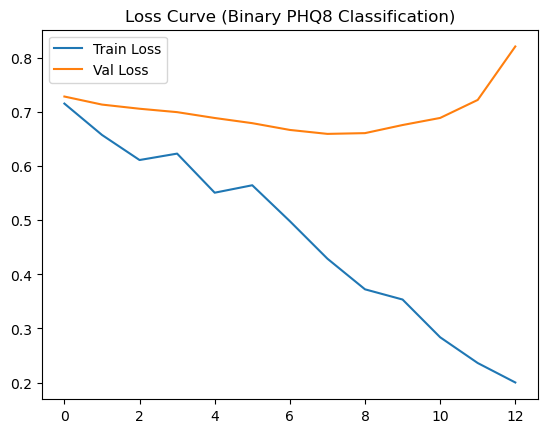

In [98]:
import os
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ==== Load PHQ-8 Labels ====
labels_df = pd.read_csv("combined_PHQ8_scores.csv")
labels_df["Participant_ID"] = labels_df["Participant_ID"].astype(str)
labels_df["PHQ8_Binary"] = (labels_df["PHQ8_Score"] >= 10).astype(int)
phq_dict = dict(zip(labels_df["Participant_ID"], labels_df["PHQ8_Binary"]))

# ==== Load and Preprocess COVAREP Features ====
T = 100  # Fixed time steps
X_all, y_all = [], []

covarep_files = glob("/Users/yubeiming/Depression/*_P/*_COVAREP.csv")
for file_path in covarep_files:
    pid = os.path.basename(file_path).split("_")[0]
    if pid not in phq_dict:
        continue

    df = pd.read_csv(file_path)
    # Find voiced/unvoiced column (VUV)
    vuv_col = next((col for col in df.columns if set(df[col].unique()).issubset({0, 1}) and df[col].nunique() == 2), None)
    if vuv_col is None: continue

    df_voiced = df[df[vuv_col] == 1].drop(columns=[vuv_col], errors="ignore").fillna(0)
    if len(df_voiced) < T:
        pad = np.zeros((T - len(df_voiced), df_voiced.shape[1]))
        arr = np.vstack([df_voiced.values, pad])
    else:
        arr = df_voiced.values[:T]

    X_all.append(arr)
    y_all.append(phq_dict[pid])

X_all = np.array(X_all)
y_all = np.array(y_all)

# ==== Normalize Features ====
nsamples, timesteps, nfeatures = X_all.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all.reshape(-1, nfeatures)).reshape(nsamples, timesteps, nfeatures)

# ==== Train-Test Split ====
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42)

# ==== Compute Class Weights ====
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(enumerate(class_weights))

# ==== LSTM Model ====
model = Sequential([
    LSTM(32, input_shape=(timesteps, nfeatures)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ==== Train ====
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=4,
    validation_data=(X_test, y_test),
    class_weight=cw_dict,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# ==== Evaluation ====
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Final Accuracy: {acc:.2f}")

y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ==== Loss Curve ====
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve (Binary PHQ8 Classification)")
plt.legend()
plt.show()


In [102]:
import os
import pandas as pd
import torch
import torchaudio
import torchaudio.transforms as T
from datasets import Dataset
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import numpy as np
import evaluate

# ====== Load and preprocess PHQ-8 score data ======
df = pd.read_csv("combined_PHQ8_binary.csv")
df["Participant_ID"] = df["Participant_ID"].astype(str)

def phq8_category(score):
    if score < 5:
        return 0
    elif score < 10:
        return 1
    elif score < 15:
        return 2
    else:
        return 3

df["PHQ8_Category"] = df["PHQ8_Score"].apply(phq8_category)

AUDIO_DIR = "/Users/yubeiming/Depression"
df["path"] = df["Participant_ID"].apply(lambda x: os.path.join(AUDIO_DIR, f"{x}_P", f"{x}_AUDIO.wav"))
df = df[df["path"].apply(os.path.exists)].reset_index(drop=True)

# ====== Load Wav2Vec2 processor ======
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
vad = T.Vad(sample_rate=16000)

def preprocess(example):
    try:
        waveform, sr = torchaudio.load(example["path"])
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)
        waveform = vad(waveform)
        if waveform.sum() == 0:
            raise ValueError("VAD removed too much")
        inputs = processor(
            waveform.squeeze().numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=16000 * 20
        )
        return {"input_values": inputs["input_values"].squeeze(0), "labels": int(example["PHQ8_Category"])}
    except Exception as e:
        print(f"[VAD Error] {example['path']}: {e}")
        return {"input_values": None, "labels": None}

# ====== Dataset + filtering bad samples ======
dataset = Dataset.from_pandas(df[["path", "PHQ8_Category"]])
dataset = dataset.map(preprocess)
dataset = dataset.filter(lambda x: x["input_values"] is not None)

# ====== Split ======
split = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = split["train"]
eval_ds = split["test"]

# ====== Model ======
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=4,
    problem_type="single_label_classification"
)

# ====== Trainer and Arguments ======
args = TrainingArguments(
    output_dir="./wav2vec2_multiclass",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=DataCollatorWithPadding(processor),
    tokenizer=processor
)

# ====== Train and Evaluate ======
trainer.train()
eval_results = trainer.evaluate()
print("✅ Final Eval:", eval_results)


/opt/anaconda3/lib/python3.12/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

[VAD Error] /Users/yubeiming/Depression/354_P/354_AUDIO.wav: VAD removed too much
[VAD Error] /Users/yubeiming/Depression/365_P/365_AUDIO.wav: VAD removed too much
[VAD Error] /Users/yubeiming/Depression/431_P/431_AUDIO.wav: VAD removed too much
[VAD Error] /Users/yubeiming/Depression/432_P/432_AUDIO.wav: VAD removed too much
[VAD Error] /Users/yubeiming/Depression/427_P/427_AUDIO.wav: VAD removed too much
[VAD Error] /Users/yubeiming/Depression/437_P/437_AUDIO.wav: VAD removed too much
[VAD Error] /Users/yubeiming/Depression/441_P/441_AUDIO.wav: VAD removed too much
[VAD Error] /Users/yubeiming/Depression/475_P/475_AUDIO.wav: VAD removed too much
[VAD Error] /Users/yubeiming/Depression/479_P/479_AUDIO.wav: VAD removed too much
[VAD Error] /Users/yubeiming/Depression/487_P/487_AUDIO.wav: VAD removed too much


Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gp/6yrz6lk90p9fh8sy2bz0lllc0000gn/T/ipykernel_80196/3132471515.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,1.359700
20,1.289800
30,1.346800
40,1.348100
50,1.268500
60,1.205200
70,1.365400
80,1.274700
90,1.236900
100,1.323200


✅ Final Eval: {'eval_loss': 1.234763741493225, 'eval_runtime': 15.7179, 'eval_samples_per_second': 1.781, 'eval_steps_per_second': 0.445, 'epoch': 5.0}


In [114]:
import os
import torch
import torchaudio
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import evaluate
import webrtcvad

# Step 1: Load and categorize labels
df = pd.read_csv("combined_PHQ8_binary.csv")
def categorize(score):
    if score <= 4: return 0
    elif score <= 9: return 1
    elif score <= 14: return 2
    return 3
df["PHQ8_Category"] = df["PHQ8_Score"].apply(categorize)

# Step 2: Add paths
AUDIO_DIR = "/Users/yubeiming/Depression"
df["path"] = df["Participant_ID"].apply(lambda x: os.path.join(AUDIO_DIR, f"{x}_P", f"{x}_AUDIO.wav"))
df = df[df["path"].apply(os.path.exists)].reset_index(drop=True)

# Step 3: VAD
vad = webrtcvad.Vad(2)
def apply_vad(path):
    try:
        waveform, sr = torchaudio.load(path)
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)
        samples = waveform.squeeze().numpy()
        pcm = (samples * 32768).astype(np.int16).tobytes()
        win = int(0.03 * 16000) * 2
        voiced = [pcm[i:i+win] for i in range(0, len(pcm)-win, win) if vad.is_speech(pcm[i:i+win], 16000)]
        if len(voiced) < 10:
            return None
        combined = b''.join(voiced)
        return torch.tensor(np.frombuffer(combined, dtype=np.int16).astype(np.float32) / 32768.0)
    except Exception:
        return None

# Step 4: Processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

# Step 5: Preprocessing
def preprocess(batch):
    audio = apply_vad(batch["path"])
    if audio is None:
        return {"input_values": None, "labels": None}
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding="max_length", truncation=True, max_length=16000*10)
    return {"input_values": inputs["input_values"][0], "labels": int(batch["PHQ8_Category"])}

dataset = Dataset.from_pandas(df[["path", "PHQ8_Category"]])
dataset = dataset.map(preprocess)
dataset = dataset.filter(lambda x: x["input_values"] is not None)

# Step 6: Split and Train
train_test = dataset.train_test_split(test_size=0.2)
train_ds, eval_ds = train_test["train"], train_test["test"]

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=4, problem_type="single_label_classification"
)

metric = evaluate.load("accuracy")
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)

args = TrainingArguments(
    output_dir="./wav2vec_multiclass",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    logging_steps=5,
    save_total_limit=1
)

collator = DataCollatorWithPadding(processor)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=processor,
    data_collator=collator,
    compute_metrics=compute_metrics
)

trainer.train()
results = trainer.evaluate()
print("✅ Final Evaluation:", results)


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
5,1.362100
10,1.157700
15,1.722100
20,1.473300
25,1.313400
30,1.137200
35,1.421700
40,1.439700
45,1.214500
50,1.326900


✅ Final Evaluation: {'eval_loss': 1.321621298789978, 'eval_accuracy': 0.43333333333333335, 'eval_runtime': 8.3393, 'eval_samples_per_second': 3.597, 'eval_steps_per_second': 1.799, 'epoch': 3.0}


In [112]:
!pip install webrtcvad


python(50407) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Preparing metadata (setup.py) ... done
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp312-cp312-macosx_11_0_arm64.whl size=25966 sha256=3146b7ae45c7598799c8288e6b740b8c0ad695e2a74ed423fbfc94e9146fd809
  Stored in directory: /Users/yubeiming/Library/Caches/pip/wheels/1e/d3/95/680fa3b16848f1a58d2edaed34c496224c89a9bc63e17b3614
Successfully built webrtcvad
